In [1]:
# Core utilities moved to fire_model package
import numpy as np
import matplotlib.pyplot as plt
from fire_model.ca import FireEnv, FireState, CAFireModel
from fire_model.boundary import (
    FireBoundary,
    between_boundaries_mask,
    candidates_from_mask,
    extract_fire_boundary,
    plot_fire_boundary,
)
from fire_model.harmonic import (
    HarmonicStripMap,
    BoundaryMap,
    build_harmonic_strip_map_uniform,
    plot_strip_map,
    sd_to_xy_theta,
    build_boundary_map,
    plot_boundary_correspondence,
)
from fire_model.bo import (
    RetardantDropBayesOpt,
    SearchGridProjector,
    TiedXYFiMatern,
    expected_improvement,
)

import fire_model.bo as bo

### Environment Set-Up incl. a Small, High-Value Asset (e.g. Town or Property)

In [2]:
# Grid / domain
nx = ny = 120
domain_km = 5

# Time discretisation (used for indexing time-varying wind and for FireState.t)
dt_s = 5.0

# Fire physics parameters
burn_time_s0 = 15 * 60         # how long a cell stays "burning" after ignition (seconds)
ros_mps = 0.25                 # baseline ROS (m/s)

# Retardant parameters
retardant_half_life_s = 2400.0 # seconds (e.g., 40 minutes)
retardant_k = 1.25             # attenuation strength exp(-k * retardant)

# Spatial maps
xs = np.linspace(-1.0, 1.0, nx)[:, None]
ys = np.linspace(-1.0, 1.0, ny)[None, :]
fuel = 0.7 + 0.9 * np.exp(-3.0 * (xs**2 + ys**2))
fuel = np.ones((nx, ny), dtype=float)
value = 1.0 + 10.0 * np.exp(-15.0 * ((xs+0.5) ** 2 + (ys - 0.25) ** 2))

# Constant wind: mild south-westerly
wind=np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = -5
wind[..., 1] = 15.0  # 5 m/s northwards

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    wind=wind,
    fuel=fuel,
    value=value,
    dt_s=dt_s,
    burn_time_s0=burn_time_s0,
    retardant_half_life_s=retardant_half_life_s,
    retardant_k=retardant_k,
    ros_mps=ros_mps,
    # wind_coeff is unused by the Finsler model, but can exist in the env
    wind_coeff=0.6,
    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.25,
)

ca_model = CAFireModel(env,seed=42)

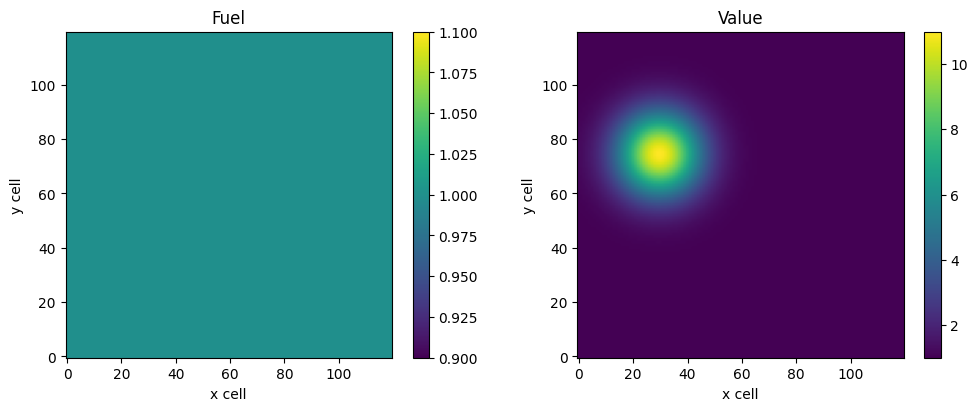

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

im0 = ax[0].imshow(fuel.T, origin="lower", aspect="equal")
ax[0].set_title("Fuel")
ax[0].set_xlabel("x cell"); ax[0].set_ylabel("y cell")
fig.colorbar(im0, ax=ax[0], fraction=0.046)

im1 = ax[1].imshow(value.T, origin="lower", aspect="equal")
ax[1].set_title("Value")
ax[1].set_xlabel("x cell"); ax[1].set_ylabel("y cell")
fig.colorbar(im1, ax=ax[1], fraction=0.046)

plt.show()

### Ignition and Search Domain - Here fire is already significant at time-of-arrival

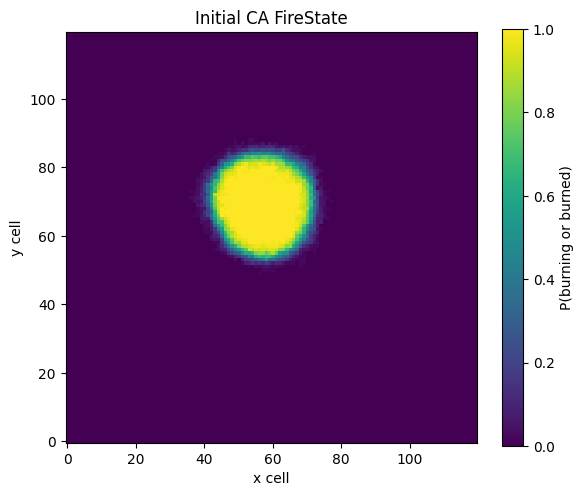

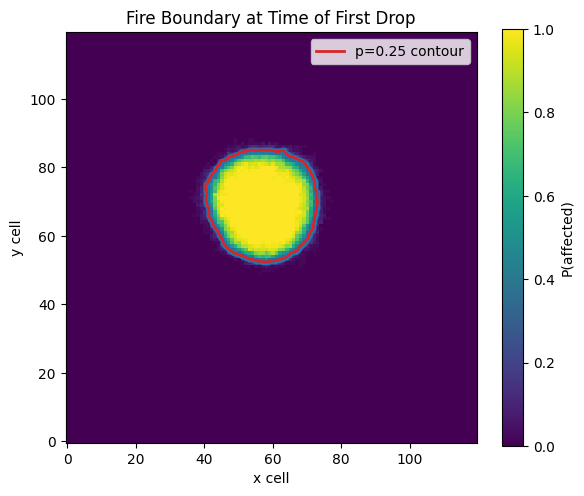

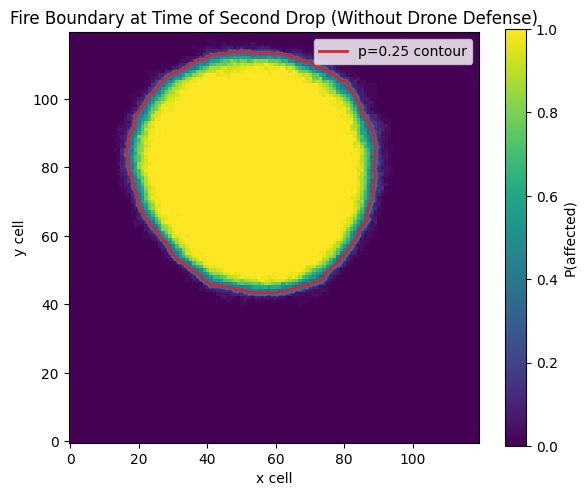

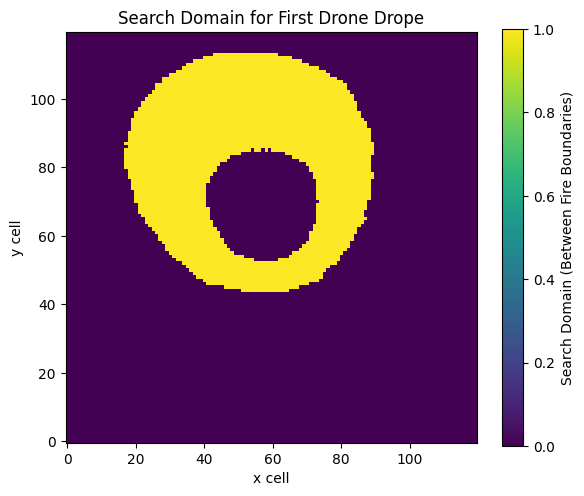

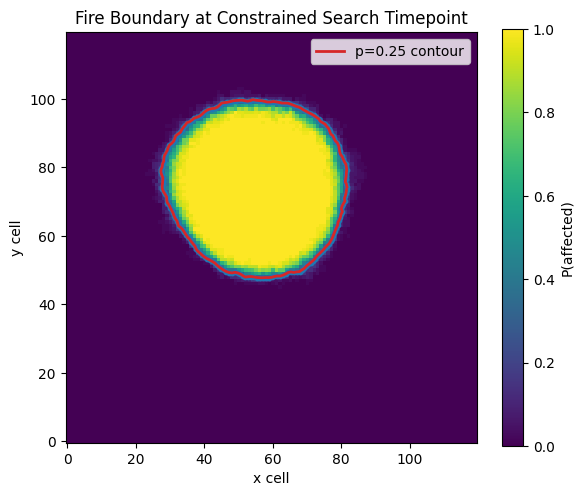

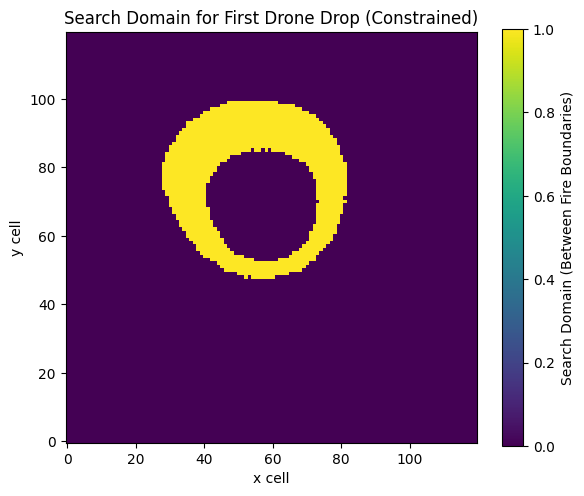

In [4]:
# Ignition and time until drones reach the fire
ignition_center = (nx // 2, ny // 2)
ignition_radius_km = 0.01
time_to_first_drop = 150.0  
time_to_second_drop = 310.0 #
search_space_time = (time_to_second_drop - time_to_first_drop)//2

# Initial Evolution
init_firestate_ca = ca_model.simulate_from_ignition(
    center=ignition_center,
    radius_km=ignition_radius_km,
    n_sims=50,
    T=time_to_first_drop
)

ca_model.plot_firestate(init_firestate_ca,title="Initial CA FireState")

# Visualising the boundary
init_boundary = extract_fire_boundary(
    init_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    init_firestate_ca,
    init_boundary,
    field="affected",
    title="Fire Boundary at Time of First Drop"
)

# Visualising the search domain
second_firestate_ca = ca_model.simulate_from_firestate(
    init_firestate=init_firestate_ca,
    T=time_to_second_drop - time_to_first_drop, # assumes we want to search the whole space between first & second drop (smaller might be better in practice)
    n_sims=50,
)

second_boundary = extract_fire_boundary(
    second_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    second_firestate_ca,
    second_boundary,
    field="affected",
    title="Fire Boundary at Time of Second Drop (Without Drone Defense)"
)

between_boundaries_mask = ca_model.discretise_between_boundaries(init_boundary, second_boundary)

ca_model.plot_search_domain(between_boundaries_mask,title="Search Domain for First Drone Drope")

# Extra constrained search space

constrained_firestate_ca = ca_model.simulate_from_firestate(
    init_firestate=init_firestate_ca,
    T=search_space_time, # assumes we want to search the whole space between first & second drop (smaller might be better in practice)
    n_sims=50,
)

constrained_boundary = extract_fire_boundary(
    constrained_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    constrained_firestate_ca,
    constrained_boundary,
    field="affected",
    title="Fire Boundary at Constrained Search Timepoint"
)

between_boundaries_mask = ca_model.discretise_between_boundaries(init_boundary, constrained_boundary)

ca_model.plot_search_domain(between_boundaries_mask,title="Search Domain for First Drone Drop (Constrained)")

### Bayesian Optimisation Set-Up

In [5]:
from fire_model.bo import RetardantDropBayesOpt

constrained_search_time = (time_to_second_drop - time_to_first_drop)*2//3

drop_opt = RetardantDropBayesOpt(
    fire_model=ca_model,
    init_firestate=init_firestate_ca,
    n_drones=4,
    evolution_time_s=time_to_second_drop-time_to_first_drop,
    search_grid_evolution_time_s=constrained_search_time,
    n_sims=50,
    fire_boundary_probability=0.25,
)

### Purely Heuristic-Based (No BO)

[Heuristic] Search grid set up with 1283 valid cells in grid.


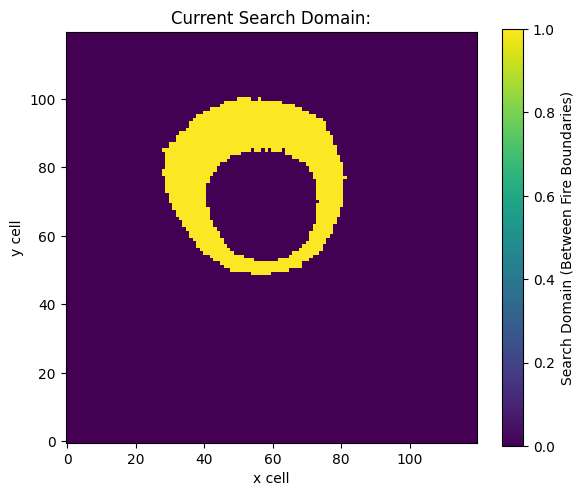

[Heuristic] eval 001/200 | y=10.8486 | best=10.8486
           (x,y,phi) per drone:
           [[39.         86.          4.20108381]
 [54.         92.          4.30125644]
 [67.         93.          4.22416347]
 [77.         77.          5.93212044]]
[Heuristic] eval 020/200 | y=10.8082 | best=7.80321
           (x,y,phi) per drone:
           [[38.         87.          4.13255643]
 [46.         93.          4.30277449]
 [66.         91.          4.0900152 ]
 [76.         73.          5.9262315 ]]
[Heuristic] eval 040/200 | y=8.22305 | best=7.80321
           (x,y,phi) per drone:
           [[33.         73.          3.60727009]
 [36.         64.          3.30431405]
 [46.         89.          4.618579  ]
 [63.         92.          4.19215318]]
[Heuristic] eval 060/200 | y=10.857 | best=7.80321
           (x,y,phi) per drone:
           [[40.         61.          2.97460237]
 [40.         87.          3.93050151]
 [56.         91.          4.73020667]
 [76.         78.          5.6364

In [6]:
best_theta, best_params, best_y, (X_feats, y_arr), y_nexts, y_bests =drop_opt.run_heuristic_search(
    n_evals=200,
    heuristic_random_frac=0.0,
    print_every=20,
)

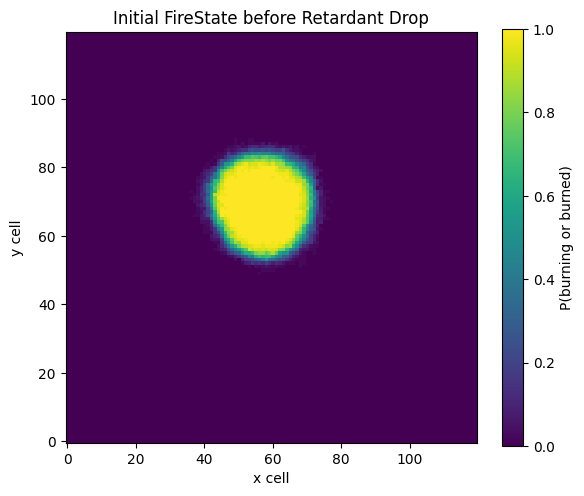

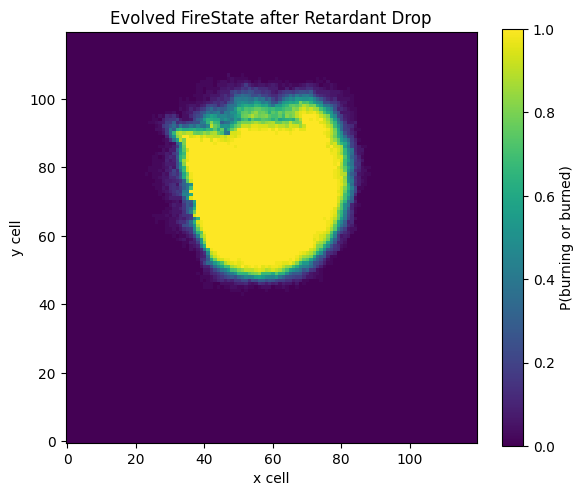

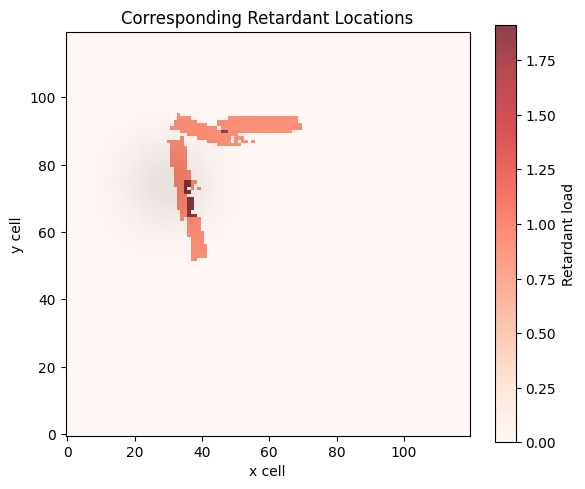

In [7]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

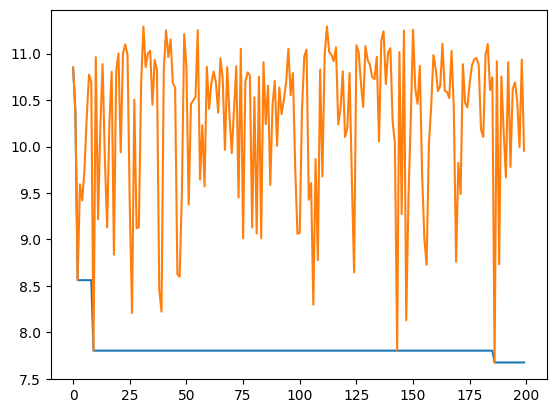

In [8]:
plt.plot(y_bests)
plt.plot(y_nexts)

### Bayesian Optimisation (Random Mask Initialisation)

In [9]:
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12,
    xi=0.01, 
    verbose=True,
    init_strategy="random_mask",
    candidate_strategy="qmc",
    candidate_qmc="sobol",
    print_every=10,
)

[BO] init: n_init=50, dim=12, n_cells=1283
[BO] init: best_y=8.23276, mean_y=10.2647, std_y=0.763552
[BO] iter 001/150 | y_next=10.1855 | best_y=8.23276 (no-improve) | EI_max=0.0242 | mu=9.20138 | std=0.689
      proposed (x,y,phi) per drone:
      [[28.         85.          5.6075962 ]
 [30.         70.          0.9905534 ]
 [48.         50.          0.28745153]
 [68.         51.          1.51903831]]
      gp.kernel_ = 0.918**2 * TiedXYFiMatern(lx=0.104, ly=768, lphi=4.91, nu=2.5) + WhiteKernel(noise_level=0.331)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packa

[BO] iter 010/150 | y_next=9.87546 | best_y=8.23276 (no-improve) | EI_max=0.00247 | mu=9.61369 | std=0.614
      proposed (x,y,phi) per drone:
      [[28.         85.          4.07099882]
 [30.         70.          5.29251214]
 [51.         90.          0.6194485 ]
 [68.         51.          0.35142733]]
      gp.kernel_ = 0.761**2 * TiedXYFiMatern(lx=0.163, ly=494, lphi=8.07, nu=2.5) + WhiteKernel(noise_level=0.569)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 020/150 | y_next=10.2387 | best_y=8.23276 (no-improve) | EI_max=0.00479 | mu=9.43059 | std=0.598
      proposed (x,y,phi) per drone:
      [[34.         63.          0.57767953]
 [34.         63.          3.87716561]
 [37.         94.          4.97952588]
 [38.         57.          1.0953675 ]]
      gp.kernel_ = 0.731**2 * TiedXYFiMatern(lx=0.125, ly=651, lphi=7.24, nu=2.5) + WhiteKernel(noise_level=0.516)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 030/150 | y_next=9.8769 | best_y=8.23276 (no-improve) | EI_max=0.00452 | mu=9.32132 | std=0.547
      proposed (x,y,phi) per drone:
      [[30.         70.          0.87207633]
 [32.         66.          1.6479086 ]
 [32.         66.          2.41706512]
 [36.         93.          5.06217854]]
      gp.kernel_ = 0.738**2 * TiedXYFiMatern(lx=0.13, ly=1.02, lphi=11, nu=2.5) + WhiteKernel(noise_level=0.454)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 040/150 | y_next=9.18714 | best_y=8.23276 (no-improve) | EI_max=0.00307 | mu=9.42752 | std=0.558
      proposed (x,y,phi) per drone:
      [[2.80000000e+01 8.50000000e+01 5.68232625e+00]
 [3.00000000e+01 7.00000000e+01 1.04862670e-02]
 [3.10000000e+01 6.80000000e+01 5.91494347e+00]
 [4.00000000e+01 5.50000000e+01 1.39741884e+00]]
      gp.kernel_ = 0.742**2 * TiedXYFiMatern(lx=0.151, ly=1.14, lphi=11.3, nu=2.5) + WhiteKernel(noise_level=0.483)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 050/150 | y_next=9.45201 | best_y=8.23276 (no-improve) | EI_max=0.0034 | mu=9.42009 | std=0.563
      proposed (x,y,phi) per drone:
      [[28.         78.          4.29774394]
 [32.         66.          4.66615687]
 [32.         89.          3.17874232]
 [32.         89.          5.9382524 ]]
      gp.kernel_ = 0.755**2 * TiedXYFiMatern(lx=0.181, ly=971, lphi=895, nu=2.5) + WhiteKernel(noise_level=0.545)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 060/150 | y_next=9.59067 | best_y=8.23276 (no-improve) | EI_max=0.00248 | mu=9.43356 | std=0.544
      proposed (x,y,phi) per drone:
      [[28.         85.          6.24252001]
 [34.         63.          3.44626673]
 [38.         57.          2.39108903]
 [38.         95.          0.52887827]]
      gp.kernel_ = 0.77**2 * TiedXYFiMatern(lx=0.178, ly=1.02, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.519)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 070/150 | y_next=9.16537 | best_y=8.23276 (no-improve) | EI_max=0.00252 | mu=9.45088 | std=0.552
      proposed (x,y,phi) per drone:
      [[28.         85.          3.35139165]
 [30.         87.          2.85468786]
 [32.         66.          3.1153761 ]
 [32.         89.          2.36796554]]
      gp.kernel_ = 1.18**2 * TiedXYFiMatern(lx=0.429, ly=5.01, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.551)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 080/150 | y_next=8.89077 | best_y=8.23276 (no-improve) | EI_max=0.00161 | mu=9.49635 | std=0.538
      proposed (x,y,phi) per drone:
      [[28.         85.          1.8604489 ]
 [29.         73.          4.75398695]
 [29.         81.          4.40777512]
 [44.         88.          2.40686228]]
      gp.kernel_ = 1.13**2 * TiedXYFiMatern(lx=0.336, ly=3.35, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.532)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 090/150 | y_next=8.97017 | best_y=8.23276 (no-improve) | EI_max=0.00165 | mu=9.4203 | std=0.511
      proposed (x,y,phi) per drone:
      [[2.80000000e+01 8.50000000e+01 7.69338834e-01]
 [3.00000000e+01 7.00000000e+01 2.91818684e+00]
 [3.30000000e+01 7.20000000e+01 5.56480779e+00]
 [4.20000000e+01 9.70000000e+01 8.73438633e-02]]
      gp.kernel_ = 1.15**2 * TiedXYFiMatern(lx=0.329, ly=2.55, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.513)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 100/150 | y_next=9.55665 | best_y=8.23276 (no-improve) | EI_max=0.00136 | mu=9.44717 | std=0.509
      proposed (x,y,phi) per drone:
      [[28.         78.          2.60801271]
 [28.         85.          5.80695323]
 [36.         60.          0.63575863]
 [40.         96.          3.20007301]]
      gp.kernel_ = 1.15**2 * TiedXYFiMatern(lx=0.305, ly=2.09, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.495)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 110/150 | y_next=9.21166 | best_y=8.23276 (no-improve) | EI_max=0.00167 | mu=9.34993 | std=0.485
      proposed (x,y,phi) per drone:
      [[28.         85.          3.57829154]
 [29.         73.          3.45348456]
 [32.         66.          0.97459666]
 [36.         93.          1.99746569]]
      gp.kernel_ = 1.15**2 * TiedXYFiMatern(lx=0.273, ly=2.03, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.48)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 120/150 | y_next=9.60714 | best_y=8.23276 (no-improve) | EI_max=0.00366 | mu=9.19044 | std=0.475
      proposed (x,y,phi) per drone:
      [[28.         78.          0.91562774]
 [29.         73.          2.07964148]
 [29.         73.          2.92709243]
 [56.         85.          1.42893761]]
      gp.kernel_ = 1.23**2 * TiedXYFiMatern(lx=0.4, ly=0.325, lphi=41.2, nu=2.5) + WhiteKernel(noise_level=0.358)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 130/150 | y_next=9.70575 | best_y=8.23276 (no-improve) | EI_max=0.00919 | mu=9.05358 | std=0.491
      proposed (x,y,phi) per drone:
      [[28.         79.          5.9517853 ]
 [29.         73.          6.22351276]
 [43.         79.          4.01223783]
 [43.         79.          5.33735498]]
      gp.kernel_ = 1.21**2 * TiedXYFiMatern(lx=0.367, ly=0.364, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.369)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 140/150 | y_next=9.30641 | best_y=8.23276 (no-improve) | EI_max=0.00141 | mu=9.43343 | std=0.506
      proposed (x,y,phi) per drone:
      [[29.         73.          2.39892048]
 [40.         55.          0.97522836]
 [41.         76.          3.97173654]
 [46.         82.          4.35867077]]
      gp.kernel_ = 1.31**2 * TiedXYFiMatern(lx=0.489, ly=0.4, lphi=31.6, nu=2.5) + WhiteKernel(noise_level=0.384)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 150/150 | y_next=9.3768 | best_y=8.23276 (no-improve) | EI_max=0.00396 | mu=9.13455 | std=0.457
      proposed (x,y,phi) per drone:
      [[28.         85.          3.03519803]
 [34.         63.          5.29876534]
 [35.         82.          2.31575451]
 [43.         91.          4.25063952]]
      gp.kernel_ = 1.14**2 * TiedXYFiMatern(lx=0.242, ly=0.499, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.397)
[BO] done: best_y=8.23276
[BO] best params:
[[33.         83.          0.10923424]
 [37.         65.          0.54000082]
 [47.         90.          6.27787188]
 [70.         94.          5.70573237]]


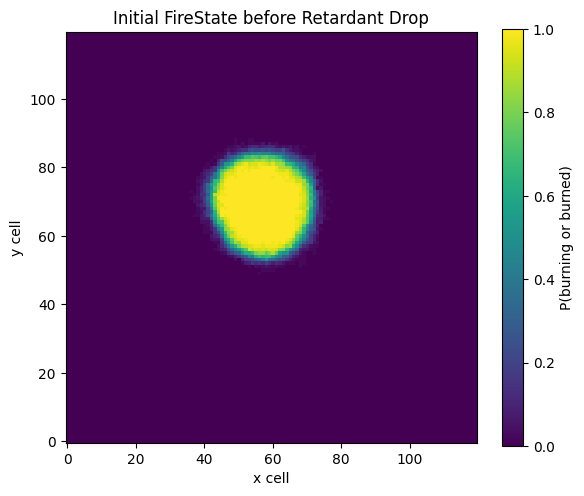

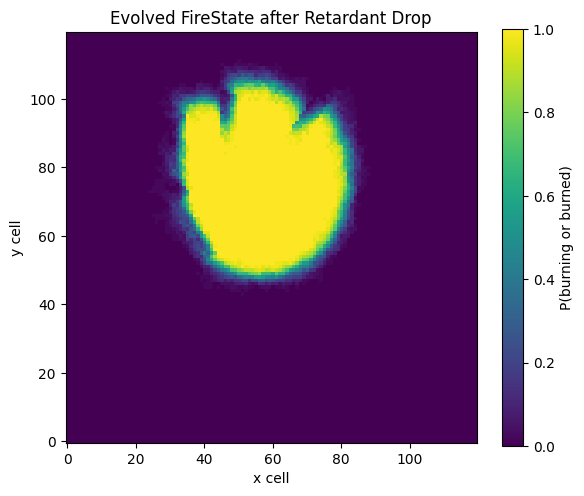

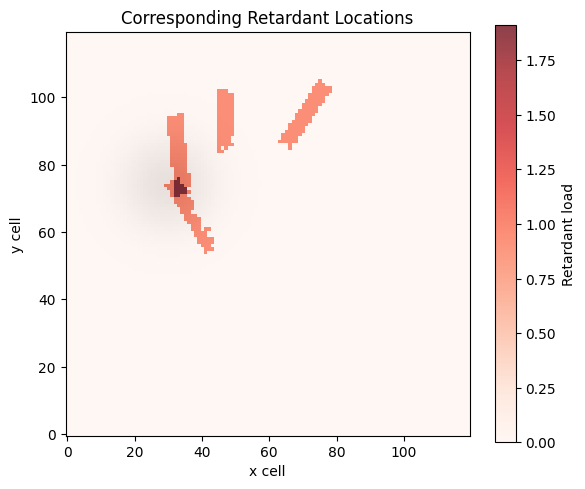

In [10]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

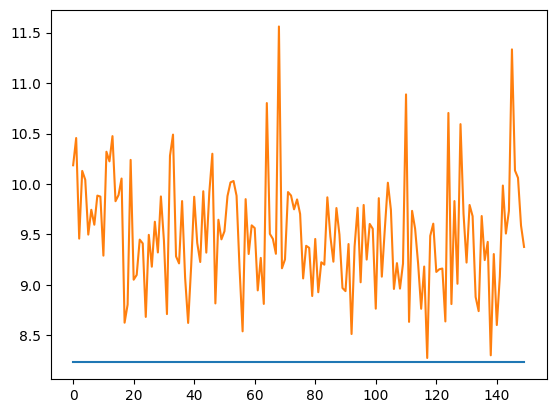

In [11]:
plt.plot(y_bests)
plt.plot(y_nexts)

### Bayesian Optimisation (Heuristic + Random Initialisation)

In [12]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12,
    xi=0.01, 
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.3, #% of initial points that are random (the rest are heuristic initialised)
    print_every=10,
    candidate_strategy="qmc",
    candidate_qmc="sobol",
)

[BO] init: n_init=50, dim=12, n_cells=1284
[BO] init: best_y=8.53644, mean_y=10.42, std_y=0.805526


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 001/150 | y_next=9.91017 | best_y=8.53644 (no-improve) | EI_max=0.00565 | mu=9.96626 | std=0.711
      proposed (x,y,phi) per drone:
      [[28.         78.          0.22828366]
 [36.         85.          1.3872069 ]
 [46.         51.          3.25712169]
 [54.         49.          2.8240687 ]]
      gp.kernel_ = 0.939**2 * TiedXYFiMatern(lx=1e+03, ly=0.0871, lphi=1.36, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-p

[BO] iter 010/150 | y_next=10.4924 | best_y=8.53644 (no-improve) | EI_max=0.0131 | mu=9.65652 | std=0.675
      proposed (x,y,phi) per drone:
      [[29.         81.          5.30742469]
 [40.         73.          3.10020932]
 [48.         50.          2.85558476]
 [58.         49.          4.21425868]]
      gp.kernel_ = 0.937**2 * TiedXYFiMatern(lx=0.302, ly=0.102, lphi=1.37, nu=2.5) + WhiteKernel(noise_level=0.0356)
[BO] iter 020/150 | y_next=8.69876 | best_y=8.53644 (no-improve) | EI_max=0.00461 | mu=9.91413 | std=0.668
      proposed (x,y,phi) per drone:
      [[28.         78.          0.74020547]
 [32.         83.          2.60429126]
 [38.         57.          3.33799429]
 [40.         55.          4.00534232]]
      gp.kernel_ = 0.925**2 * TiedXYFiMatern(lx=0.291, ly=0.0909, lphi=1.36, nu=2.5) + WhiteKernel(noise_level=0.0379)
[BO] iter 030/150 | y_next=9.73033 | best_y=8.53644 (no-improve) | EI_max=0.0107 | mu=9.6591 | std=0.65
      proposed (x,y,phi) per drone:
      [[30. 

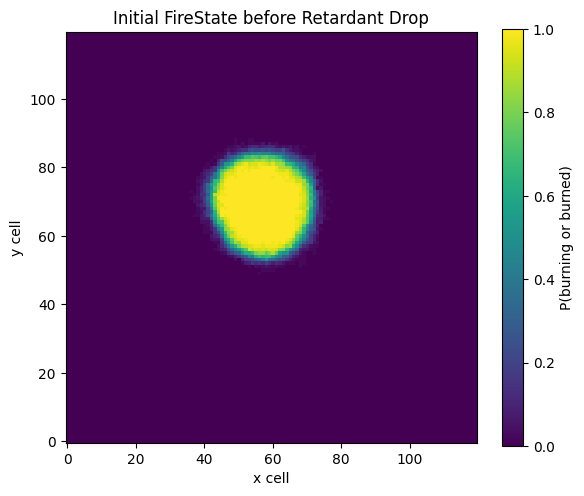

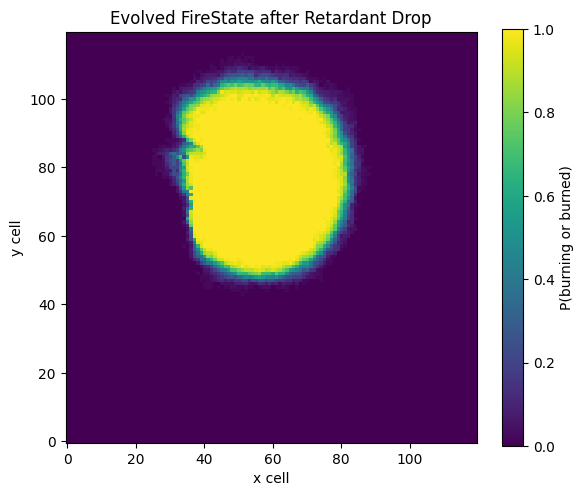

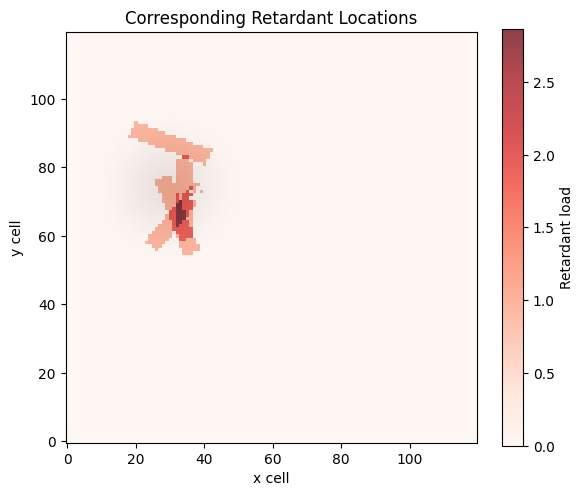

In [13]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

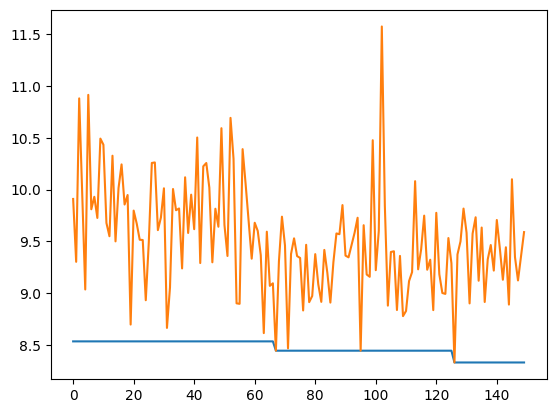

In [14]:
plt.plot(y_bests)
plt.plot(y_nexts)

### Heuristic Initialisation and QMC+Local Exploitation (best)

In [15]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12, #note will still hit the Sobol balance property warning since Sobol used for global (so n_candidates*(1-candidate_local_frac) should be power of 2)
    xi=0.01, 
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.3, #% of initial points that are random (the rest are heuristic initialised)
    print_every=10,
    candidate_strategy="mixed",
    candidate_qmc="sobol",
    candidate_local_frac=0.6,
    candidate_local_top_k=5,
    candidate_local_sigma_cells=4.0,
    candidate_local_sigma_phi_rad=np.deg2rad(20),
)

[BO] init: n_init=50, dim=12, n_cells=1284
[BO] init: best_y=9.04939, mean_y=10.3514, std_y=0.662432


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


[BO] iter 001/150 | y_next=10.3579 | best_y=9.04939 (no-improve) | EI_max=0.15 | mu=8.9597 | std=0.264
      proposed (x,y,phi) per drone:
      [[37.         68.          4.13183678]
 [47.         89.          4.16130108]
 [54.         91.          4.22121436]
 [65.         88.          5.81971448]]
      gp.kernel_ = 1.02**2 * TiedXYFiMatern(lx=629, ly=0.065, lphi=7.75, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is 

[BO] iter 010/150 | y_next=9.43145 | best_y=9.04939 (no-improve) | EI_max=0.0776 | mu=9.46314 | std=0.576
      proposed (x,y,phi) per drone:
      [[29.         73.          6.24983258]
 [32.         89.          3.22942301]
 [59.         92.          1.36523808]
 [63.         50.          4.25496901]]
      gp.kernel_ = 1.32**2 * TiedXYFiMatern(lx=0.287, ly=1.02, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.49)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Docum

[BO] iter 020/150 | y_next=11.0504 | best_y=8.98842 (no-improve) | EI_max=0.0989 | mu=9.13565 | std=0.416
      proposed (x,y,phi) per drone:
      [[40.         71.          3.01027758]
 [41.         91.          3.38981501]
 [64.         88.          4.36740748]
 [72.         63.          5.4073729 ]]
      gp.kernel_ = 0.886**2 * TiedXYFiMatern(lx=0.628, ly=0.142, lphi=1.81, nu=2.5) + WhiteKernel(noise_level=0.213)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/q

[BO] iter 030/150 | y_next=9.37154 | best_y=8.47404 (no-improve) | EI_max=0.0437 | mu=8.7339 | std=0.348
      proposed (x,y,phi) per drone:
      [[33.         81.          3.28882635]
 [42.         93.          2.75613315]
 [63.         86.          4.92524058]
 [76.         64.          6.24100116]]
      gp.kernel_ = 0.895**2 * TiedXYFiMatern(lx=0.0577, ly=0.402, lphi=2.84, nu=2.5) + WhiteKernel(noise_level=0.103)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 040/150 | y_next=8.36656 | best_y=8.36656 (improved) | EI_max=0.022 | mu=9.05869 | std=0.464
      proposed (x,y,phi) per drone:
      [[34.         69.          2.87006533]
 [40.         84.          2.29245605]
 [64.         86.          4.93237174]
 [78.         72.          0.66855787]]
      gp.kernel_ = 0.886**2 * TiedXYFiMatern(lx=0.103, ly=162, lphi=4.68, nu=2.5) + WhiteKernel(noise_level=0.281)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  w

[BO] iter 050/150 | y_next=9.4506 | best_y=8.29773 (no-improve) | EI_max=0.0132 | mu=8.95726 | std=0.447
      proposed (x,y,phi) per drone:
      [[33.         67.          2.74419803]
 [39.         92.          2.37594046]
 [62.         86.          5.22133934]
 [79.         71.          0.78723086]]
      gp.kernel_ = 0.921**2 * TiedXYFiMatern(lx=0.119, ly=781, lphi=5.5, nu=2.5) + WhiteKernel(noise_level=0.273)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = samp

[BO] iter 060/150 | y_next=8.88962 | best_y=8.151 (no-improve) | EI_max=0.0208 | mu=8.68079 | std=0.426
      proposed (x,y,phi) per drone:
      [[35.         76.          2.83127977]
 [35.         91.          2.40972093]
 [64.         87.          4.05848688]
 [78.         85.          1.04963053]]
      gp.kernel_ = 0.927**2 * TiedXYFiMatern(lx=0.0941, ly=902, lphi=6.53, nu=2.5) + WhiteKernel(noise_level=0.211)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Docum

[BO] iter 070/150 | y_next=9.47629 | best_y=8.1142 (no-improve) | EI_max=0.0234 | mu=8.6725 | std=0.457
      proposed (x,y,phi) per drone:
      [[33.         67.          3.93603593]
 [33.         90.          3.00305609]
 [64.         88.          4.68836267]
 [80.         80.          0.71763061]]
      gp.kernel_ = 0.924**2 * TiedXYFiMatern(lx=0.114, ly=667, lphi=5.33, nu=2.5) + WhiteKernel(noise_level=0.215)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Docum

[BO] iter 080/150 | y_next=7.97432 | best_y=7.97432 (improved) | EI_max=0.023 | mu=8.5331 | std=0.43
      proposed (x,y,phi) per drone:
      [[34.         84.          3.37622961]
 [35.         71.          3.29859731]
 [63.         89.          5.16003385]
 [78.         85.          0.4461654 ]]
      gp.kernel_ = 0.917**2 * TiedXYFiMatern(lx=0.117, ly=1.95, lphi=4.9, nu=2.5) + WhiteKernel(noise_level=0.201)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 090/150 | y_next=7.55697 | best_y=7.52172 (no-improve) | EI_max=0.00712 | mu=8.30669 | std=0.452
      proposed (x,y,phi) per drone:
      [[35.         69.          2.94624118]
 [35.         75.          2.99244273]
 [63.         93.          4.59195051]
 [76.         88.          0.42818425]]
      gp.kernel_ = 0.91**2 * TiedXYFiMatern(lx=0.119, ly=0.408, lphi=5.12, nu=2.5) + WhiteKernel(noise_level=0.18)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 100/150 | y_next=8.11585 | best_y=7.50972 (no-improve) | EI_max=0.0368 | mu=7.80717 | std=0.351
      proposed (x,y,phi) per drone:
      [[33.         71.          3.0922682 ]
 [35.         76.          3.3875964 ]
 [63.         95.          4.87287576]
 [77.         88.          0.21846665]]
      gp.kernel_ = 0.915**2 * TiedXYFiMatern(lx=0.113, ly=0.33, lphi=2.91, nu=2.5) + WhiteKernel(noise_level=0.106)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 110/150 | y_next=7.47146 | best_y=7.41088 (no-improve) | EI_max=0.0467 | mu=7.62065 | std=0.32
      proposed (x,y,phi) per drone:
      [[3.50000000e+01 7.50000000e+01 3.23010923e+00]
 [3.60000000e+01 7.20000000e+01 3.11023296e+00]
 [6.40000000e+01 9.00000000e+01 4.42442884e+00]
 [7.80000000e+01 8.50000000e+01 8.63375533e-02]]
      gp.kernel_ = 0.937**2 * TiedXYFiMatern(lx=0.112, ly=0.31, lphi=3.04, nu=2.5) + WhiteKernel(noise_level=0.0754)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 120/150 | y_next=7.31117 | best_y=7.31117 (improved) | EI_max=0.0417 | mu=7.54238 | std=0.263
      proposed (x,y,phi) per drone:
      [[36.         74.          2.99639189]
 [36.         78.          3.07559124]
 [62.         93.          4.62199876]
 [78.         86.          0.53351029]]
      gp.kernel_ = 0.965**2 * TiedXYFiMatern(lx=0.113, ly=0.289, lphi=2.6, nu=2.5) + WhiteKernel(noise_level=0.044)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 130/150 | y_next=7.52539 | best_y=7.31117 (no-improve) | EI_max=0.0425 | mu=7.45895 | std=0.257
      proposed (x,y,phi) per drone:
      [[35.         75.          3.30489481]
 [35.         77.          2.94512014]
 [64.         91.          4.2969518 ]
 [74.         82.          0.48646222]]
      gp.kernel_ = 1.01**2 * TiedXYFiMatern(lx=0.111, ly=0.212, lphi=2.46, nu=2.5) + WhiteKernel(noise_level=0.0143)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 140/150 | y_next=10.8799 | best_y=7.17778 (no-improve) | EI_max=0.0144 | mu=9.26807 | std=1.14
      proposed (x,y,phi) per drone:
      [[36.         60.          4.24591345]
 [37.         94.          3.69503449]
 [40.         96.          1.5233824 ]
 [42.         97.          6.08775025]]
      gp.kernel_ = 1.04**2 * TiedXYFiMatern(lx=0.115, ly=0.213, lphi=2.52, nu=2.5) + WhiteKernel(noise_level=0.00847)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 150/150 | y_next=9.92972 | best_y=7.17778 (no-improve) | EI_max=0.00956 | mu=9.46979 | std=1.15
      proposed (x,y,phi) per drone:
      [[28.         79.          5.51482142]
 [28.         85.          5.69429703]
 [29.         79.          4.48823725]
 [55.         97.          1.37609888]]
      gp.kernel_ = 1.05**2 * TiedXYFiMatern(lx=0.122, ly=0.222, lphi=2.61, nu=2.5) + WhiteKernel(noise_level=0.0101)
[BO] done: best_y=7.17778
[BO] best params:
[[35.         72.          3.14501504]
 [36.         76.          2.79574331]
 [63.         91.          4.36451471]
 [76.         79.          0.26531131]]


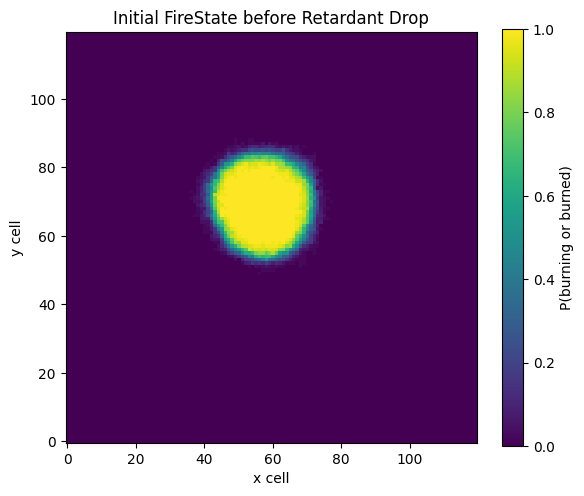

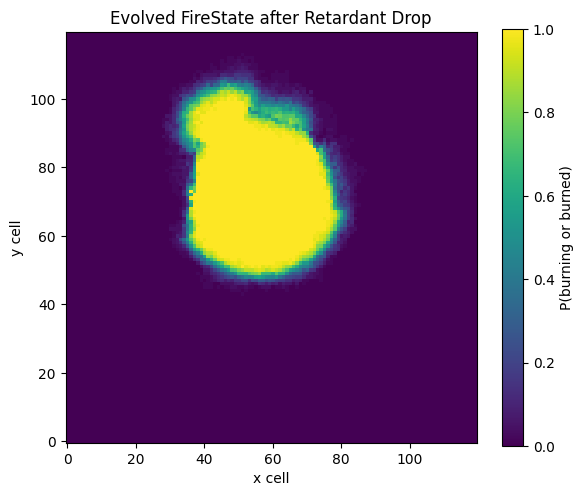

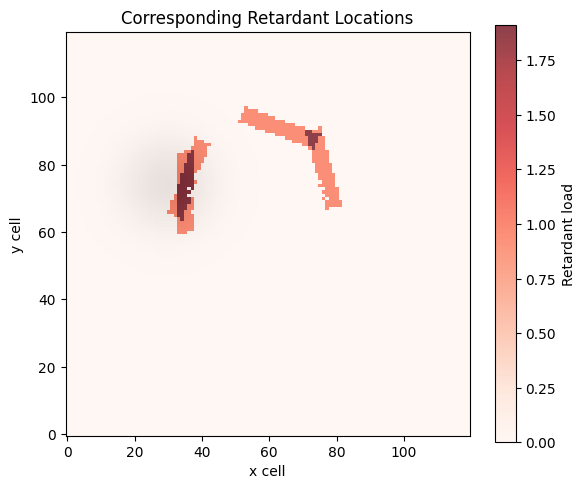

In [16]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

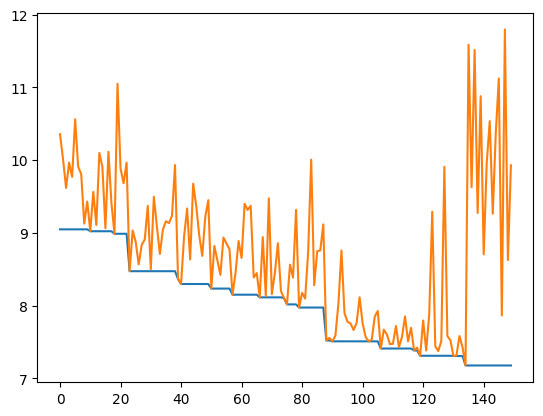

In [17]:
plt.plot(y_bests)
plt.plot(y_nexts)

### Same as above (Heuristic init + mixed global/local sampling for acquisition) but more total inits and x_i turned up a bit

In [18]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=80,
    n_iters=160,
    n_candidates=2**12, #note will still hit the Sobol balance property warning since Sobol used for global (so n_candidates*(1-candidate_local_frac) should be power of 2)
    xi=0.03,  # coefficient to encourage exploration
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.3, #% of initial points that are random (the rest are heuristic initialised)
    print_every=20,
    candidate_strategy="mixed",
    candidate_qmc="sobol",
    candidate_local_frac=0.65,
    candidate_local_top_k=5, 
    candidate_local_sigma_cells=4.0,
    candidate_local_sigma_phi_rad=np.deg2rad(20),
)

[BO] init: n_init=80, dim=12, n_cells=1284
[BO] init: best_y=8.09731, mean_y=10.3611, std_y=0.781042


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


[BO] iter 001/160 | y_next=9.51071 | best_y=8.09731 (no-improve) | EI_max=0.139 | mu=8.18138 | std=0.477
      proposed (x,y,phi) per drone:
      [[37.         70.          3.08043446]
 [40.         71.          3.22872105]
 [45.         88.          3.06391925]
 [66.         92.          5.17283956]]
      gp.kernel_ = 1**2 * TiedXYFiMatern(lx=318, ly=0.087, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.0529)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to 

[BO] iter 020/160 | y_next=7.76788 | best_y=7.76788 (improved) | EI_max=0.00655 | mu=8.62027 | std=0.407
      proposed (x,y,phi) per drone:
      [[3.40000000e+01 6.30000000e+01 3.15133409e+00]
 [3.50000000e+01 7.70000000e+01 3.10373480e+00]
 [3.60000000e+01 9.30000000e+01 2.77524198e+00]
 [6.30000000e+01 9.30000000e+01 5.99124658e-02]]
      gp.kernel_ = 0.776**2 * TiedXYFiMatern(lx=0.631, ly=0.101, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.136)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = samp

[BO] iter 040/160 | y_next=8.33924 | best_y=7.63906 (no-improve) | EI_max=0.0127 | mu=8.22231 | std=0.414
      proposed (x,y,phi) per drone:
      [[32.         66.          3.31519759]
 [33.         76.          3.32575937]
 [33.         90.          3.28779626]
 [75.         93.          0.85398212]]
      gp.kernel_ = 0.752**2 * TiedXYFiMatern(lx=0.418, ly=0.125, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.115)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/q

[BO] iter 060/160 | y_next=7.99399 | best_y=7.63906 (no-improve) | EI_max=0.00738 | mu=8.20652 | std=0.361
      proposed (x,y,phi) per drone:
      [[34.         63.          2.77241811]
 [34.         77.          3.07069301]
 [35.         89.          2.60561157]
 [67.         94.          0.27089842]]
      gp.kernel_ = 0.8**2 * TiedXYFiMatern(lx=0.701, ly=0.123, lphi=8.07, nu=2.5) + WhiteKernel(noise_level=0.0825)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 080/160 | y_next=8.3909 | best_y=7.63906 (no-improve) | EI_max=0.0169 | mu=8.23777 | std=0.452
      proposed (x,y,phi) per drone:
      [[34.         63.          5.6955041 ]
 [34.         78.          2.79669032]
 [35.         91.          3.24654461]
 [68.         95.          0.5760764 ]]
      gp.kernel_ = 0.952**2 * TiedXYFiMatern(lx=0.236, ly=0.727, lphi=28.5, nu=2.5) + WhiteKernel(noise_level=0.134)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 100/160 | y_next=8.03622 | best_y=7.63906 (no-improve) | EI_max=0.0134 | mu=8.24847 | std=0.433
      proposed (x,y,phi) per drone:
      [[34.         63.          0.19033298]
 [34.         79.          2.89700581]
 [35.         91.          3.06449662]
 [71.         95.          0.31826663]]
      gp.kernel_ = 0.971**2 * TiedXYFiMatern(lx=0.234, ly=0.709, lphi=25.3, nu=2.5) + WhiteKernel(noise_level=0.122)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 120/160 | y_next=7.57613 | best_y=7.5086 (no-improve) | EI_max=0.0136 | mu=8.09578 | std=0.423
      proposed (x,y,phi) per drone:
      [[34.         63.          2.96294671]
 [34.         74.          2.87687578]
 [35.         85.          2.72194598]
 [71.         90.          0.66615564]]
      gp.kernel_ = 0.921**2 * TiedXYFiMatern(lx=0.198, ly=0.722, lphi=14.5, nu=2.5) + WhiteKernel(noise_level=0.11)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 140/160 | y_next=8.03047 | best_y=7.20613 (no-improve) | EI_max=0.00782 | mu=7.7897 | std=0.373
      proposed (x,y,phi) per drone:
      [[34.         64.          2.0214717 ]
 [34.         74.          2.94521705]
 [34.         84.          2.71388536]
 [69.         85.          0.94592969]]
      gp.kernel_ = 0.92**2 * TiedXYFiMatern(lx=0.157, ly=0.406, lphi=9.92, nu=2.5) + WhiteKernel(noise_level=0.0775)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 160/160 | y_next=6.99223 | best_y=6.72504 (no-improve) | EI_max=0.0141 | mu=6.92974 | std=0.211
      proposed (x,y,phi) per drone:
      [[36.         72.          3.37491709]
 [36.         73.          3.14277326]
 [37.         83.          3.02000871]
 [68.         85.          1.53529283]]
      gp.kernel_ = 0.975**2 * TiedXYFiMatern(lx=0.135, ly=0.212, lphi=2.56, nu=2.5) + WhiteKernel(noise_level=0.00347)
[BO] done: best_y=6.72504
[BO] best params:
[[35.         69.          3.061043  ]
 [37.         74.          2.9310624 ]
 [37.         81.          2.79305693]
 [71.         88.          1.39854745]]


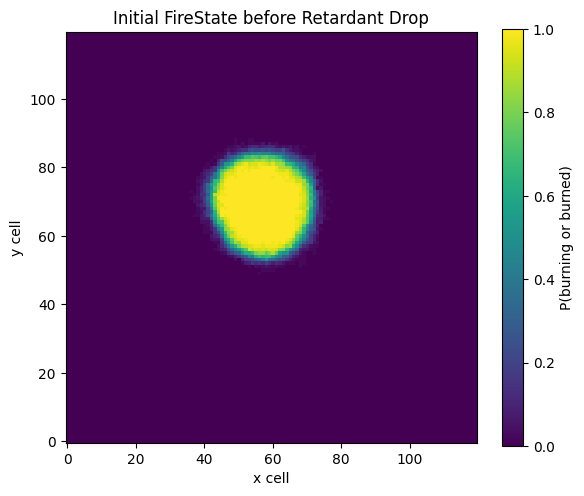

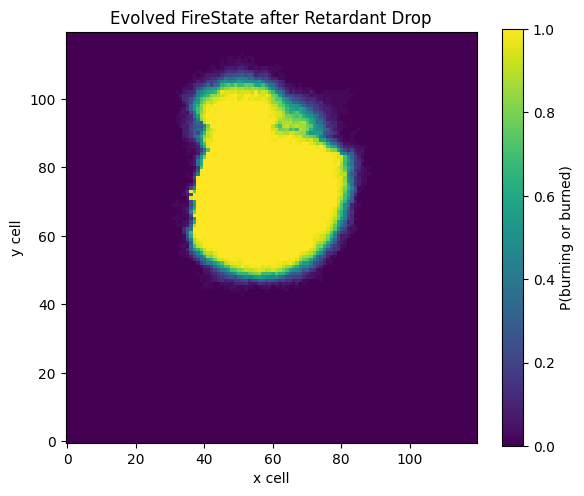

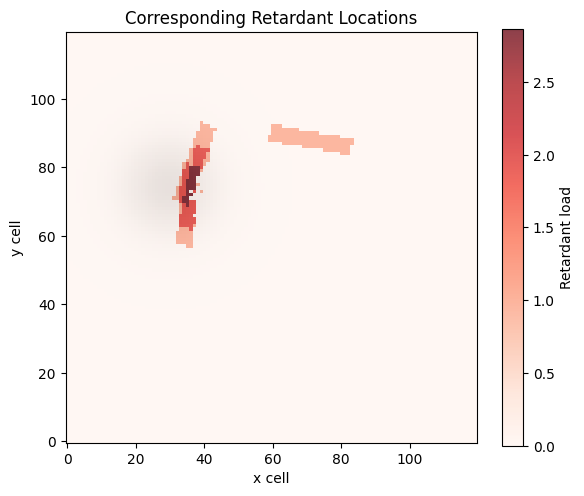

In [19]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

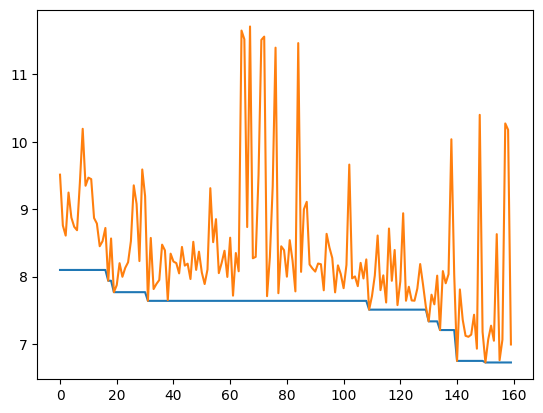

In [20]:
plt.plot(y_bests)
plt.plot(y_nexts)

### Exploitation focused

In [21]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12, #note will still hit the Sobol balance property warning since Sobol used for global (so n_candidates*(1-candidate_local_frac) should be power of 2)
    xi=0.01, 
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.3, #% of initial points that are random (the rest are heuristic initialised)
    print_every=10,
    candidate_strategy="mixed",
    candidate_qmc="sobol",
    candidate_local_frac=0.5,
    candidate_local_top_k=10,
    candidate_local_sigma_cells=3.0,
    candidate_local_sigma_phi_rad=np.deg2rad(15),
    candidate_global_masked=True
)

[BO] init: n_init=50, dim=12, n_cells=1284
[BO] init: best_y=8.10338, mean_y=10.1214, std_y=0.88053


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 001/150 | y_next=9.64408 | best_y=8.10338 (no-improve) | EI_max=0.498 | mu=7.64775 | std=0.505
      proposed (x,y,phi) per drone:
      [[29.         73.          3.44933337]
 [43.         93.          4.47268156]
 [58.         90.          4.89821702]
 [72.         90.          4.97733449]]
      gp.kernel_ = 1.14**2 * TiedXYFiMatern(lx=0.0951, ly=0.363, lphi=885, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packa

[BO] iter 010/150 | y_next=9.74066 | best_y=8.10338 (no-improve) | EI_max=0.0154 | mu=8.88116 | std=0.525
      proposed (x,y,phi) per drone:
      [[33.         69.          3.61819852]
 [37.         59.          2.50021676]
 [56.         85.          4.59426463]
 [75.         93.          5.08564666]]
      gp.kernel_ = 0.875**2 * TiedXYFiMatern(lx=0.0827, ly=0.366, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.148)
[BO] iter 020/150 | y_next=10.0468 | best_y=8.10338 (no-improve) | EI_max=0.0212 | mu=8.73706 | std=0.487
      proposed (x,y,phi) per drone:
      [[36.         61.          3.760862  ]
 [36.         84.          4.35372237]
 [39.         65.          2.85188717]
 [68.         97.          4.19122967]]
      gp.kernel_ = 0.865**2 * TiedXYFiMatern(lx=0.0885, ly=0.463, lphi=6.16, nu=2.5) + WhiteKernel(noise_level=0.182)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 030/150 | y_next=8.74632 | best_y=8.10338 (no-improve) | EI_max=0.0131 | mu=8.9858 | std=0.559
      proposed (x,y,phi) per drone:
      [[32.         66.          1.19478224]
 [32.         89.          3.02064825]
 [33.         71.          3.55760599]
 [74.         91.          2.56005206]]
      gp.kernel_ = 0.928**2 * TiedXYFiMatern(lx=0.171, ly=0.689, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.328)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 040/150 | y_next=8.93685 | best_y=8.10338 (no-improve) | EI_max=0.0116 | mu=8.92259 | std=0.514
      proposed (x,y,phi) per drone:
      [[34.         63.          3.73175428]
 [34.         64.          3.13771215]
 [34.         79.          4.60448374]
 [72.         95.          5.1623878 ]]
      gp.kernel_ = 0.909**2 * TiedXYFiMatern(lx=0.137, ly=0.671, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.268)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 050/150 | y_next=9.17411 | best_y=8.10338 (no-improve) | EI_max=0.00624 | mu=8.9949 | std=0.489
      proposed (x,y,phi) per drone:
      [[32.         69.          3.7387503 ]
 [32.         89.          4.62119614]
 [33.         65.          3.25973802]
 [70.         89.          4.88994382]]
      gp.kernel_ = 1.02**2 * TiedXYFiMatern(lx=0.205, ly=0.837, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.31)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 060/150 | y_next=9.57882 | best_y=8.10338 (no-improve) | EI_max=0.00622 | mu=8.98512 | std=0.484
      proposed (x,y,phi) per drone:
      [[32.         66.          4.22315321]
 [36.         93.          0.17969363]
 [37.         87.          2.42566667]
 [73.         77.          3.15791132]]
      gp.kernel_ = 1.07**2 * TiedXYFiMatern(lx=0.219, ly=0.845, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.316)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 070/150 | y_next=9.2499 | best_y=8.10338 (no-improve) | EI_max=0.0066 | mu=8.99573 | std=0.494
      proposed (x,y,phi) per drone:
      [[30.         70.          3.34106679]
 [33.         67.          3.52681724]
 [33.         89.          4.56566584]
 [68.         97.          5.04413102]]
      gp.kernel_ = 1.12**2 * TiedXYFiMatern(lx=0.23, ly=0.842, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.325)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 080/150 | y_next=9.08424 | best_y=8.10338 (no-improve) | EI_max=0.00733 | mu=8.9182 | std=0.468
      proposed (x,y,phi) per drone:
      [[32.         66.          2.95183631]
 [32.         76.          1.43360094]
 [33.         65.          3.2460052 ]
 [62.         97.          4.70852681]]
      gp.kernel_ = 1.11**2 * TiedXYFiMatern(lx=0.206, ly=0.791, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.298)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 090/150 | y_next=8.68444 | best_y=8.10338 (no-improve) | EI_max=0.00587 | mu=8.84325 | std=0.416
      proposed (x,y,phi) per drone:
      [[32.         67.          3.33472227]
 [32.         68.          2.56444446]
 [32.         82.          1.60317712]
 [66.         97.          4.97274812]]
      gp.kernel_ = 1.09**2 * TiedXYFiMatern(lx=0.175, ly=0.744, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.265)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 100/150 | y_next=8.69682 | best_y=7.98926 (no-improve) | EI_max=0.00852 | mu=8.65209 | std=0.409
      proposed (x,y,phi) per drone:
      [[34.         63.          2.9801901 ]
 [34.         63.          3.29136405]
 [34.         83.          5.28799151]
 [64.         84.          5.07964586]]
      gp.kernel_ = 1.05**2 * TiedXYFiMatern(lx=0.142, ly=0.726, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.235)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 110/150 | y_next=8.28747 | best_y=7.9787 (no-improve) | EI_max=0.0185 | mu=8.47289 | std=0.392
      proposed (x,y,phi) per drone:
      [[34.         75.          2.37357075]
 [34.         76.          2.1295956 ]
 [34.         85.          5.42682011]
 [62.         87.          5.13912898]]
      gp.kernel_ = 1.04**2 * TiedXYFiMatern(lx=0.121, ly=0.77, lphi=14.9, nu=2.5) + WhiteKernel(noise_level=0.197)
[BO] iter 120/150 | y_next=8.34102 | best_y=7.82913 (no-improve) | EI_max=0.0276 | mu=8.17203 | std=0.345
      proposed (x,y,phi) per drone:
      [[33.         78.          2.71386722]
 [34.         78.          1.90287066]
 [34.         80.          5.79882212]
 [62.         99.          5.27771786]]
      gp.kernel_ = 1.03**2 * TiedXYFiMatern(lx=0.11, ly=0.782, lphi=8.5, nu=2.5) + WhiteKernel(noise_level=0.15)
[BO] iter 130/150 | y_next=8.74339 | best_y=7.71675 (no-improve) | EI_max=0.0296 | mu=8.09401 | std=0.376
      proposed (x,y,phi) per drone:
      [[33.         8

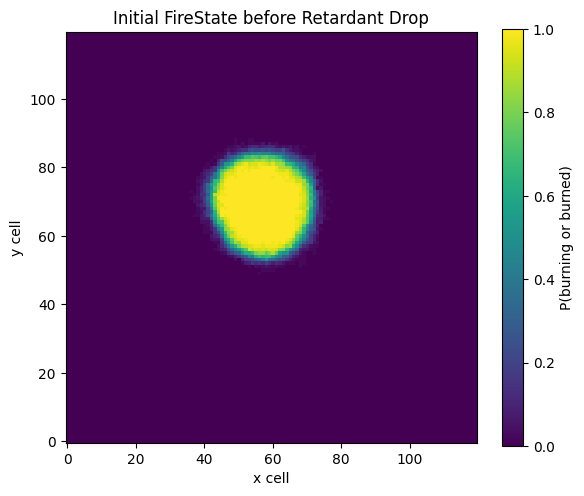

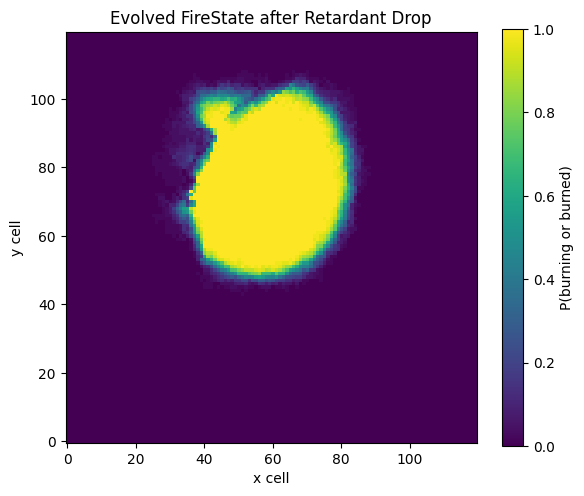

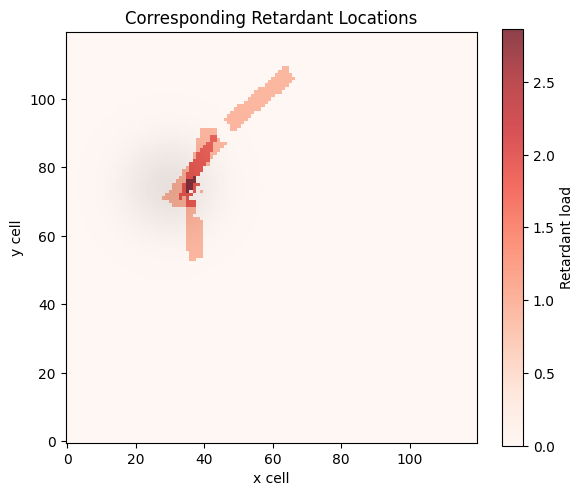

In [22]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

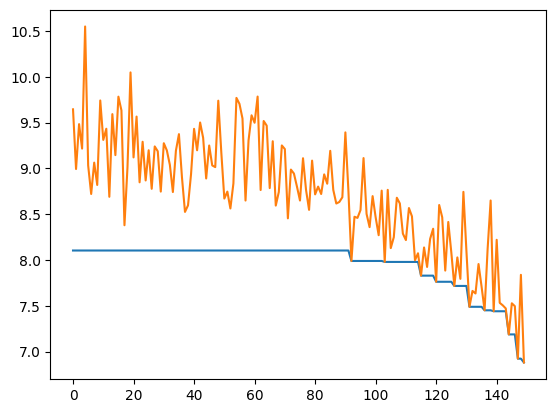

In [23]:
plt.plot(y_bests)
plt.plot(y_nexts)

### More Phi Exploration

In [ ]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12, #note will still hit the Sobol balance property warning since Sobol used for global (so n_candidates*(1-candidate_local_frac) should be power of 2)
    xi=0.01, 
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.3, #% of initial points that are random (the rest are heuristic initialised)
    print_every=10,
    candidate_strategy="mixed",
    candidate_qmc="sobol",
    candidate_local_frac=0.6,
    candidate_local_top_k=5,
    candidate_local_sigma_cells=4.0,
    candidate_local_sigma_phi_rad=np.deg2rad(30), #increased to encourage more phi exploration
    candidate_local_resample_phi_prob=0.25, #default is 0.05 - prob of resampling phi when generating local candidates
    candidate_global_masked=True
)

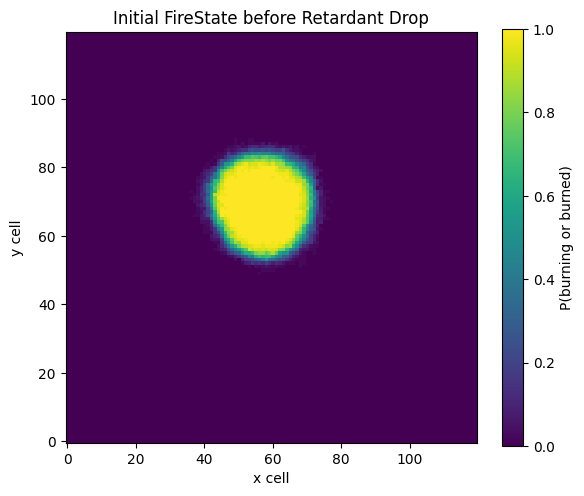

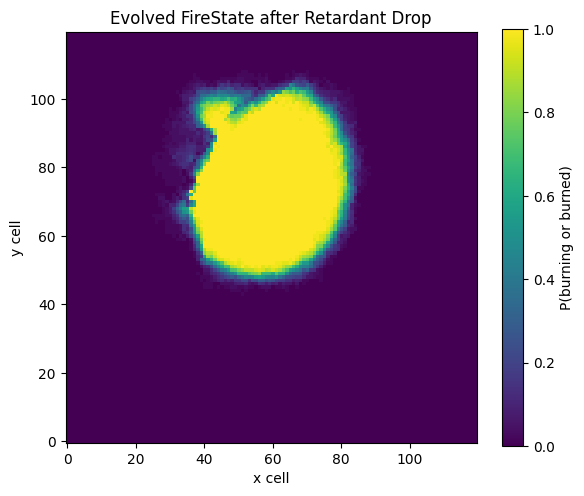

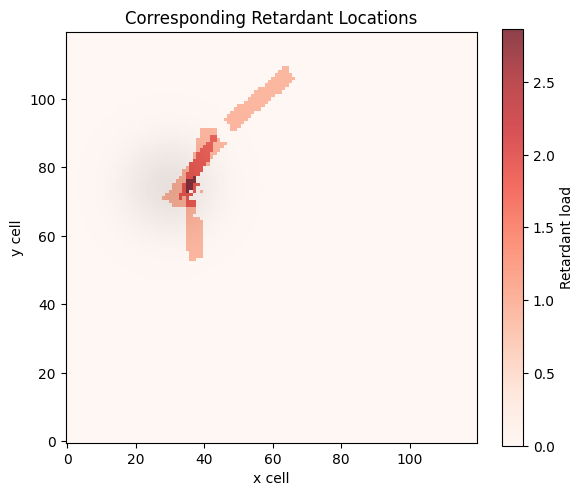

In [24]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

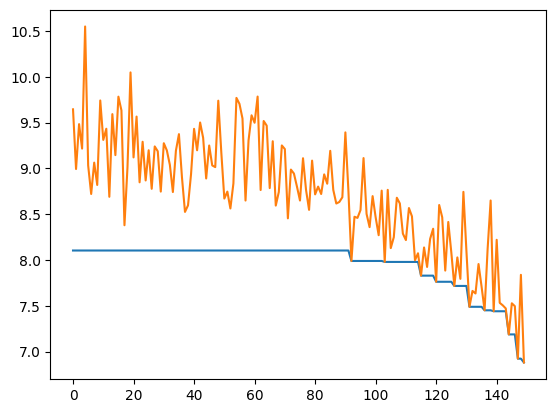

In [25]:
plt.plot(y_bests)
plt.plot(y_nexts)